Instructions  
Data Preparation: Select a portion of the S&P 500 stock data for analysis. Perform preprocessing steps such as feature selection, normalization, and scaling to make the data suitable for the RNN model.  
Model Development: Construct an RNN model using libraries like TensorFlow, or PyTorch. Incorporate LSTM units to address the vanishing gradient problem and improve memory retention across time steps.  
Training: Train the RNN model on the prepared dataset, optimizing the loss function and choosing an appropriate optimizer to enhance model performance.  
Prediction: Enable the model to forecast future stock prices, starting from a given initial stock price input.
Ensure the RNN model efficiently learns from the selected stock price data and accurately forecasts future trends.  

Note: To evaluate the performance of the RNN model, you can use metrics like Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE). You can also try different hyperparameters and compare the results to find the best configuration for the RNN model. Additionally, you can explore different methods for visualizing the forecasted stock prices, such as line charts and candlestick charts.

Data: M3-AAPL.csv/zip 

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
# from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler # for normalization
from sklearn.metrics import mean_squared_error
print(tf.__version__)

2.17.0


In [62]:
# 1. Load the dataset
df = pd.read_csv('M3-AAPL.csv')
pd.set_option('display.max_columns', None)
display(df.head(10))
display(df.dtypes)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-05-28,44.730000,45.147499,44.477501,44.557499,43.002316,111792800
1,2019-05-29,44.105000,44.837502,44.000000,44.345001,42.797237,113924800
2,2019-05-30,44.487499,44.807499,44.167500,44.575001,43.019211,84873600
3,2019-05-31,44.057499,44.497501,43.747501,43.767502,42.239895,108174400
4,2019-06-03,43.900002,44.480000,42.567501,43.325001,41.812828,161584400
5,2019-06-04,43.860001,44.957500,43.630001,44.910000,43.342510,123872000
6,2019-06-05,46.070000,46.247501,45.285000,45.634998,44.042213,119093600
7,2019-06-06,45.770000,46.367500,45.537498,46.305000,44.688820,90105200
8,2019-06-07,46.627499,47.980000,46.442501,47.537498,45.878304,122737600
9,2019-06-10,47.952499,48.842499,47.904999,48.145000,46.464611,104883600


Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [63]:
# Feature selection

# Extract the Close price column
close_prices = df['Close'].values.astype('float32').reshape(-1, 1)

# Normalize the Close prices
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices = scaler.fit_transform(close_prices)

In [71]:
# split the data into training and test sets
train_size = int(len(close_prices) * 0.7)
test_size = len(close_prices) - train_size
train_data, test_data = close_prices[0:train_size,:], close_prices[train_size:len(close_prices),:]

In [72]:
# Create the training data
window_size = 20
X_train, y_train = [], []
for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the training data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Create the testing data
X_test, y_test = [], []
for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape the testing data for LSTM
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [73]:
# developmnet of the rnn model with lstm
def create_rnn_model_with_lstm(window_size=5):
    print('Creating RNN model with LSTM...')

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(window_size, 1)),
        tf.keras.layers.LSTM(20),
        tf.keras.layers.Dense(1)
    ])

    # rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    model.compile(optimizer='adam', loss='mse', metrics=[
                    tf.keras.losses.MeanAbsoluteError(), tf.keras.losses.MeanAbsolutePercentageError()])
    print("Model created successfully!")
    return model

model = create_rnn_model_with_lstm()

Creating RNN model with LSTM...
Model created successfully!


In [ ]:
# Train model
model.fit(X_train, y_train, epochs=200, batch_size=64)

In [75]:
# Evaluate the model on the test data
mse = model.evaluate(X_test, y_test)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - loss: 5.8176e-04 - mean_absolute_error: 0.0199 - mean_absolute_percentage_error: 2.5612


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
RMSE: 3.9712321758270264
prediction sample [133.62997]


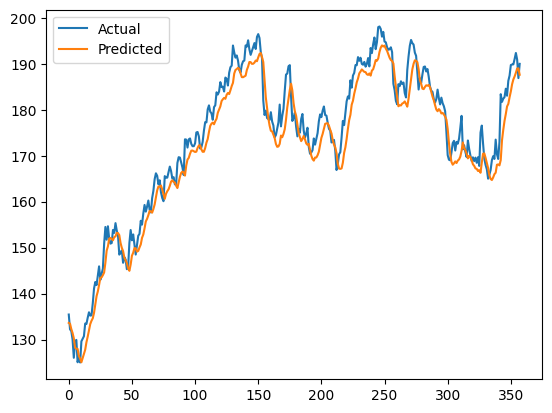

In [76]:
# predict a future stock price given stock initial price
predictions = model.predict(X_test)

# Denormalize the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE: {rmse}")
print("prediction sample", predictions[0])
# Plot the predictions and actual values
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()